In [1]:
import numpy as numpy
import pandas as pd
import matplotlib as mpl
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import joblib
from sklearn.svm import SVC
from scipy.stats import loguniform
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

In [3]:
train_df = pd.read_csv("combined_train.csv")
test_df = pd.read_csv("combined_test.csv")
train_metadata = pd.read_csv("train/train_metadata.csv")
test_metadata = pd.read_csv("test/test_metadata.csv")

In [4]:
class_ids = train_metadata["ClassId"]
test_ids = test_metadata['id']
combined_train = train_df.drop("image_path", axis = 1)
combined_test = test_df.drop("image_path", axis=1)

In [5]:
digits = pd.read_csv("./dig_feature/ocr_digit_detection.csv")
pixels = pd.read_csv("./image_flat/flattened_images.csv")
cnn = pd.read_csv("./CNN_feature/cnn_features.csv")

In [6]:
digits_test = pd.read_csv("./dig_feature/ocr_digit_detection_test.csv")
pixels_test = pd.read_csv("./image_flat/flattened_images_test.csv")
cnn_test = pd.read_csv("./CNN_feature/cnn_features_test.csv")

In [7]:
new_train = pd.concat([train_df, cnn, digits], axis=1, join="inner")
new_train = new_train.drop("image_path", axis=1)

In [8]:
new_test = pd.concat([test_df, cnn_test, digits_test], axis = 1)
new_test = new_test.drop("image_path", axis=1)

In [40]:
skf = StratifiedKFold(n_splits=5)
pipelineSVM = make_pipeline(StandardScaler(), SVC(verbose=1))
param_distributions = {
    'svc__C': loguniform(1e-3, 1e1),                  
    'svc__kernel': ['rbf'],
    'svc__gamma': loguniform(1e-3, 1e2),          
    'svc__shrinking': [True, False],                 
    'svc__class_weight': [None, 'balanced'],       
}
search = RandomizedSearchCV(
    pipelineSVM,
    param_distributions=param_distributions,
    n_iter=50,
    cv=skf,
    scoring='accuracy',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
search.fit(new_train, class_ids)
joblib.dump(search, "post-SVM.pkl")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LibSVM]

['post-SVM.pkl']

In [41]:
pd.DataFrame(search.cv_results_).sort_values(by="mean_test_score", ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__class_weight,param_svc__gamma,param_svc__kernel,param_svc__shrinking,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,25.597371,1.734821,9.944954,1.086105,2.136833,balanced,0.001009,rbf,False,"{'svc__C': 2.1368329072358767, 'svc__class_wei...",0.913479,0.899818,0.913479,0.902461,0.925251,0.910898,0.009091,1
3,34.354090,1.075032,10.363279,1.004026,0.679658,balanced,0.001915,rbf,False,"{'svc__C': 0.679657809075816, 'svc__class_weig...",0.862477,0.849727,0.867942,0.850501,0.877849,0.861699,0.010669,2
27,41.206509,4.457717,10.467580,0.837313,0.311310,balanced,0.003000,rbf,True,"{'svc__C': 0.3113095956122124, 'svc__class_wei...",0.729508,0.732240,0.747723,0.719234,0.717411,0.729223,0.010870,3
16,41.340893,1.941279,11.179355,0.568001,0.153759,balanced,0.001434,rbf,False,"{'svc__C': 0.1537592023548176, 'svc__class_wei...",0.709472,0.714026,0.719490,0.691887,0.714676,0.709910,0.009555,4
49,23.295631,6.881733,3.453423,0.436731,0.102498,balanced,0.001463,rbf,False,"{'svc__C': 0.10249816559563214, 'svc__class_we...",0.626594,0.598361,0.612022,0.604376,0.632634,0.614797,0.012991,5
32,42.413798,3.832026,11.283956,0.503957,0.123291,None,0.003585,rbf,False,"{'svc__C': 0.12329098365270515, 'svc__class_we...",0.337887,0.326958,0.331512,0.318140,0.312671,0.325434,0.009060,6
42,57.928684,2.949235,10.537549,1.352113,1.870937,None,0.033412,rbf,False,"{'svc__C': 1.8709365688887358, 'svc__class_wei...",0.090164,0.091075,0.095628,0.087511,0.089335,0.090743,0.002711,7
23,51.946018,4.439249,11.316263,0.937577,8.862327,balanced,0.094277,rbf,False,"{'svc__C': 8.862326508576253, 'svc__class_weig...",0.059199,0.058288,0.057377,0.057429,0.057429,0.057944,0.000713,8
1,63.770206,1.921762,11.379006,1.767096,0.248104,None,0.169498,rbf,True,"{'svc__C': 0.24810409748678125, 'svc__class_we...",0.057377,0.057377,0.057377,0.057429,0.057429,0.057398,0.000026,9
0,61.892702,1.847665,10.264417,1.636256,0.031489,None,0.008264,rbf,False,"{'svc__C': 0.03148911647956861, 'svc__class_we...",0.057377,0.057377,0.057377,0.057429,0.057429,0.057398,0.000026,9


In [ ]:
pipelineLogReg = make_pipeline(StandardScaler(), 
                        OneVsRestClassifier(LogisticRegression(penalty='l1', solver='saga', max_iter=4000, n_jobs=-1)))

param_grid2 = {'onevsrestclassifier__estimator__C': loguniform(1e-1, 1e1)}
oneRest = RandomizedSearchCV(pipelineLogReg, param_grid2, cv=3, n_jobs=-1, n_iter=10)
oneRest.fit(new_train, class_ids)
joblib.dump(oneRest, "post-LogReg.pkl")

c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


['post-LogReg.pkl']

In [45]:
pd.DataFrame(oneRest.cv_results_).sort_values(by="mean_test_score", ascending=False).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_onevsrestclassifier__estimator__C,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,4934.888591,85.258394,0.098703,0.004929,1.920107,{'onevsrestclassifier__estimator__C': 1.920106...,0.914754,0.896665,0.904319,0.905246,0.007414,1
2,2507.028942,105.439929,0.116931,0.008775,0.195003,{'onevsrestclassifier__estimator__C': 0.195002...,0.883060,0.870968,0.884090,0.879373,0.005958,2
0,2295.371605,125.878094,0.122198,0.007525,0.168745,{'onevsrestclassifier__estimator__C': 0.168745...,0.875956,0.866047,0.874248,0.872084,0.004325,3


In [ ]:
n_estimators =  [200, 500, 1000, 2000]
max_features = [0.01, 0.1, 'sqrt', "log2"]
max_depth = list(range(20, 111, 10))
max_depth.append(None)
min_samples_split = [2, 3, 4, 5]
min_samples_leaf = [1, 2, 3, 0.5]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

model = RandomForestClassifier(class_weight='balanced', verbose=1)
rf_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 250, cv = 3, verbose=1, n_jobs = -1, error_score='raise')
rf_random.fit(new_train, class_ids)
joblib.dump(rf_random, "post-RF.pkl")

Fitting 3 folds for each of 250 candidates, totalling 750 fits


Create a confusion matrix for the SVM

In [15]:
from sklearn.base import clone
cmGenerator = make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma=0.001009, C=2.1, verbose=1))
K=5
skf = StratifiedKFold(n_splits=K)
scores = []
cm = numpy.array(0)
for train, validation in skf.split(new_train, class_ids):
    tempModel = clone(cmGenerator)
    tempModel.fit(new_train.iloc[train], class_ids[train])
    if cm.any():
        cm += confusion_matrix(class_ids[validation], tempModel.predict(new_train.iloc[validation]), normalize='true')
    else:
        cm = confusion_matrix(class_ids[validation], tempModel.predict(new_train.iloc[validation]), normalize='true')
    scores.append(tempModel.score(new_train.iloc[validation], class_ids[validation]))
print(scores)
print(sum(scores)/len(scores))
cumCM = cm/K

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][0.9216757741347905, 0.9080145719489982, 0.9143897996357013, 0.910665451230629, 0.9371011850501367]
0.9183693564000512


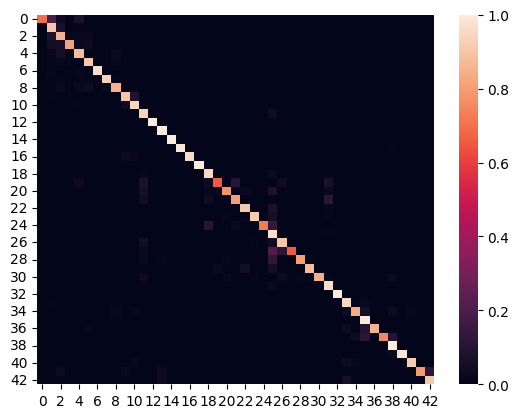

In [16]:
sns.heatmap(cumCM)
class_accuracies = sorted((cm[i][i], i) for i in range(43))

In [29]:
def printSigns(accuracies, top_n=10, reverse=False):
    if reverse:
        accuracies = list(reversed(accuracies))
    
    num_cols = top_n // 2 if top_n >= 2 else 1
    num_rows = 2 if top_n > 1 else 1

    mpl.pyplot.figure(figsize=(2.5 * num_cols, 3 * num_rows))

    for i in range(top_n):
        classID = accuracies[i][1]
        mpl.pyplot.subplot(num_rows, num_cols, i + 1)
        img = mpl.image.imread(f'./Sign Images/{classID}.png')
        mpl.pyplot.imshow(img)
        mpl.pyplot.axis('off')
        mpl.pyplot.title(f'Class {classID}', fontsize=10)

    mpl.pyplot.tight_layout()
    mpl.pyplot.show()

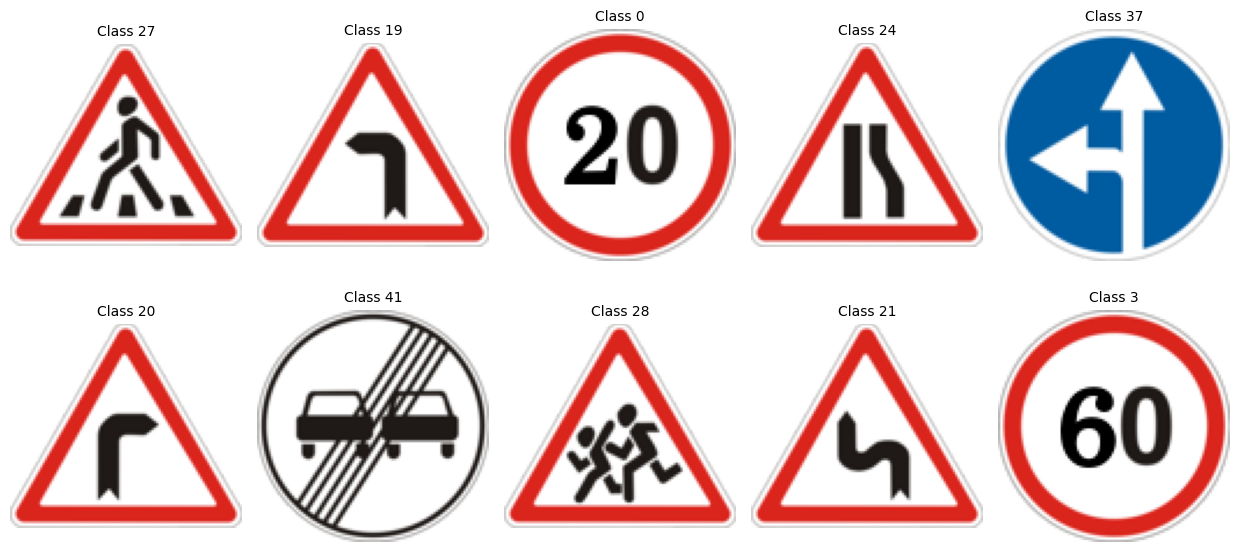

In [30]:
printSigns(class_accuracies)

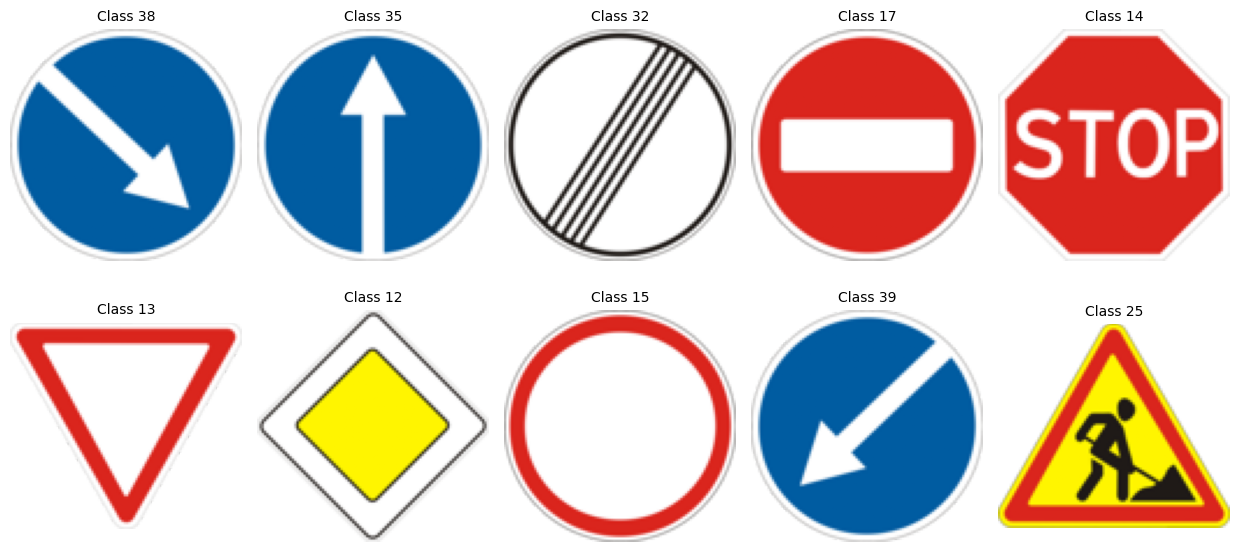

In [31]:
printSigns(class_accuracies, reverse=True)

In [ ]:
output = pd.DataFrame()
output["id"] = test_ids
output["ClassId"] = search.predict(new_test)
output.to_csv("svm_alldata_outcome.csv", index=False)

In [ ]:
output = pd.DataFrame()
output["id"] = test_ids
output["ClassId"] = oneRest.predict(new_test)
output.to_csv("logreg_alldata_outcome.csv", index=False)

In [ ]:
output = pd.DataFrame()
output["id"] = test_ids
output["ClassId"] = rf_random.predict(new_test)
output.to_csv("randomforest_alldata_outcome.csv", index=False)